In [4]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
sys.path.append('../scripts/') 

from aux_funcs import label_encoder, load_ct_scans, competition_metric, extract_img_id, get_config, make_ct_git, filter_by_std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
import tensorflow.keras.backend as K
from functools import partial
from sklearn.model_selection import GroupKFold

from sklearn.preprocessing import StandardScaler

#######################################################

def encode_categorical(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus'],1,inplace=True)

    return df

def encode_categorical_2(df):
    sex_encoding = {'Male':0, 'Female':1}
    df.Sex = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['SmokingStatus'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else (2 if x == 'Ex-smoker' else 3))

    return df

#######################################################

train_df = pd.read_csv('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/train.csv')
test_df = pd.read_csv('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/test.csv')

mask_patients = [not(x in list(test_df['Patient'].values)) for x in list(train_df['Patient'].values)]
train_df = pd.DataFrame(train_df.values[mask_patients], columns=train_df.columns)

patient_2_remove = []

for patient in list(train_df['Patient'].values):
    if patient in list(test_df['Patient'].values):
        patient_2_remove.append(patient)
        
print('Train patients in test', np.unique(patient_2_remove).shape[0])

patient_encoder = LabelEncoder()
patient_label = train_df['Patient'].values

df_train = encode_categorical(train_df)
test_df = encode_categorical(test_df)

X = df_train.drop(['Patient', 'FVC'], 1)
cols_X = X.columns
X = X.values.astype(np.float32)
Y = df_train['FVC'].values.astype(np.float32)

Train patients in test 0


In [12]:
def get_pred(y_pred):
    sigma = y_pred[-1][:, 2] - y_pred[-1][:, 0]
    fvc_pred = y_pred[-1][:, 1]

    return fvc_pred, sigma

def score(y_true, y_pred, C1=K.constant(70, dtype='float32'), C2=K.constant(1000, dtype='float32')):
    sigma = K.abs(y_pred[:, 2] - y_pred[:, 0])
    fvc_pred = y_pred[:, 1]
    fvc_true = y_true[:, 0]
    
    sigma_clip = K.maximum(sigma, C1)
    delta = K.abs(fvc_true - fvc_pred)
    delta = K.minimum(delta, C2)
    sq2 = K.sqrt(K.constant(2, dtype='float32'))

    metric = -(delta / sigma_clip)*sq2 - K.log(sigma_clip* sq2)
    return K.mean(metric)

def pinball_loss(y_true, y_pred, q):
    e = y_true - y_pred
    v = K.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(w, qs):
    q = K.constant(np.array([qs]), dtype='float32')
    def loss(y_true, y_pred, q):
        return w*(partial(pinball_loss, q=q)(y_true, y_pred)) + (1-w)*score(y_true, y_pred)
        #return (partial(pinball_loss, q=q)(y_true, y_pred))
    return partial(loss, q=q)

def make_model(w=0.8):
    ipt = keras.layers.Input((X.shape[1],))
    x = keras.layers.Dense(100, activation='relu')(ipt)
    x = keras.layers.Dense(100, activation='relu')(x)
    p1 = keras.layers.Dense(3, activation="linear", name="p1")(x)
    p2 = keras.layers.Dense(3, activation="relu", name="p2")(x)
    qs = keras.layers.Lambda(lambda x: x[0] + K.cumsum(x[1], axis=1), name="qs")([p1, p2])
    
    model = keras.models.Model(inputs=ipt, outputs=qs, name='quantile_nn')
    loss_model = mloss(w, qs=[0.2,0.5,0.8]) ; loss_model.__name__ = 'loss'

    model.compile(loss=loss_model, optimizer='adam', metrics=score)
    return model

In [13]:
'''group_kfold = GroupKFold(n_splits=5)
for train_index, test_index in group_kfold.split(X, Y, patient_label):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = make_model(0.8)
    model.fit(X_train, [Y_train, Y_train, Y_train], validation_split=0.2, batch_size=32, epochs=250, verbose=0)

    print('Test', model.evaluate(X_test, Y_test, verbose=0))'''

"group_kfold = GroupKFold(n_splits=5)\nfor train_index, test_index in group_kfold.split(X, Y, patient_label):\n    X_train, X_test = X[train_index], X[test_index]\n    Y_train, Y_test = Y[train_index], Y[test_index]\n\n    scaler = StandardScaler()\n    X_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n\n    model = make_model(0.8)\n    model.fit(X_train, [Y_train, Y_train, Y_train], validation_split=0.2, batch_size=32, epochs=250, verbose=0)\n\n    print('Test', model.evaluate(X_test, Y_test, verbose=0))"

In [14]:
 model = make_model(w=0.8)
 #model.fit(X, Y, validation_split=0.2, batch_size=32, epochs=500, verbose=1)

In [15]:
model.summary()

Model: "quantile_nn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          800         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         dense_3[0][0]                    
________________________________________________________________________________________

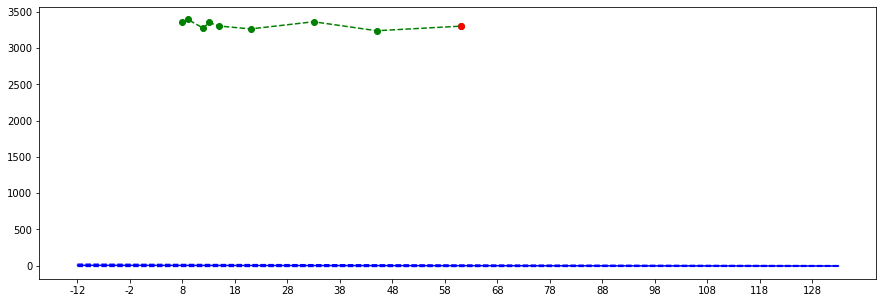

In [9]:
id_pat = X.shape[0]-1
X_pred = np.hstack([np.arange(-12,134).reshape(-1,1), np.repeat(X[id_pat:id_pat+1, 1:], 146, axis=0)])
y_model = model.predict(X_pred)
q0, pred, q2 = y_model[:,0], y_model[:,1], y_model[:,2]
sigma = q2 - q0

mask = train_df['Patient'] == patient_label[id_pat]
test_vals = train_df[['Patient', 'Weeks', 'FVC']].values[mask,1:]

plt.figure(figsize=(15,5))
plt.plot(X_pred[:,0], pred, linestyle='-', c='b')
plt.plot(X_pred[:,0], pred+sigma, linestyle='--', c='b')
plt.plot(X_pred[:,0], pred-sigma, linestyle='--', c='b')

plt.xticks(range(-12,134, 10), range(-12,134, 10))
plt.scatter(X[-9:, 0], Y[-9:], c='g')
plt.plot(X[-9:, 0], Y[-9:], linestyle='--', c='g')

plt.scatter(X[id_pat:id_pat+1, 0], Y[id_pat], c='r')
plt.show()

In [10]:
X[id_pat:id_pat+1, 0]

array([61.], dtype=float32)

In [11]:
for x in patient_label:
    print(x)

75836
ID00196637202246668775836
ID00196637202246668775836
ID00196637202246668775836
ID00196637202246668775836
ID00196637202246668775836
ID00196637202246668775836
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00197637202246865691526
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00199637202248141386743
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00202637202249376026949
ID00207637202252526380974
ID00207637202252526380974
ID00207637202252526380974
ID00207637202252526380974
ID00207637202252526380974
ID0020